# Segmentation de la clientèle du e-commerçant Olist

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from function_utils import display_circles
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
import gc

In [2]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

In [3]:
df = pd.read_csv("datasets/data_short.csv")
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,,,,,
000e309254ab1fc5ba99dd469d36bdb4,valparaiso de goias,115,2,39.210,1,2,4,124,497.666327,fashion_underwear_beach,14.0,3
0028a7d8db7b0247652509358ad8d755,valinhos,309,2,177.435,3,2,1,321,363.245845,office_furniture,23.0,3
00324c9f4d710e7bac5c5ba679714430,paraiso do tocantins,483,2,54.890,4,2,4,424,1480.276994,housewares,12.0,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37685 entries, 000e309254ab1fc5ba99dd469d36bdb4 to f448091e9f88e875eedd3f5542f0524b
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_city             37685 non-null  object 
 1   Recency                   37685 non-null  int64  
 2   Frequency                 37685 non-null  int64  
 3   MonetaryValue             37685 non-null  float64
 4   r_quartile                37685 non-null  int64  
 5   f_bins                    37685 non-null  int64  
 6   m_quartile                37685 non-null  int64  
 7   RFM_Score                 37685 non-null  int64  
 8   distance_customer_seller  37685 non-null  float64
 9   product_category_name     37111 non-null  object 
 10  nb_days_before_delivered  37685 non-null  float64
 11  review_score              37685 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 3.7+ MB


# 1) Préparation des données

In [5]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] = np.log1p(df["MonetaryValue"])
customers.reset_index(inplace=True)

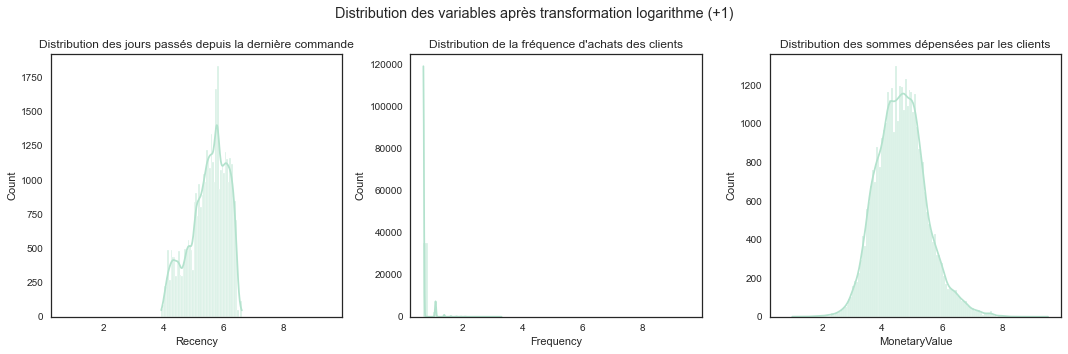

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0], x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show()

In [7]:
customers.set_index("customer_unique_id", inplace=True)

In [8]:
scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [-0.  0. -0.]
Standard Deviation: [1. 1. 1.]


La transformation logarithmique a permis de modifier la forme de la distribution des variables Recency et MonetaryValue pour qu'elle soit proche d'une distribution normale. Cette modification permet de rendre les modèles d'apprentissage non-supervisé comme l'algorithme K-Means d'être plus performant.

Une seconde étape a été de standardiser nos données. Ainsi, nos données ont toutes une moyenne de 0 avec un écart-type de 1. Là, encore cette modification a pour but d'améliorer la performance de nos modèles d'apprentissage non-supervisé. 

## Réduction de dimensions

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en 2 dimensions (même si dans ce cas, il aurait possible de les visualiser en 3 dimensions). De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering. 

In [9]:
n_comp = 2
pca = PCA(n_components=n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

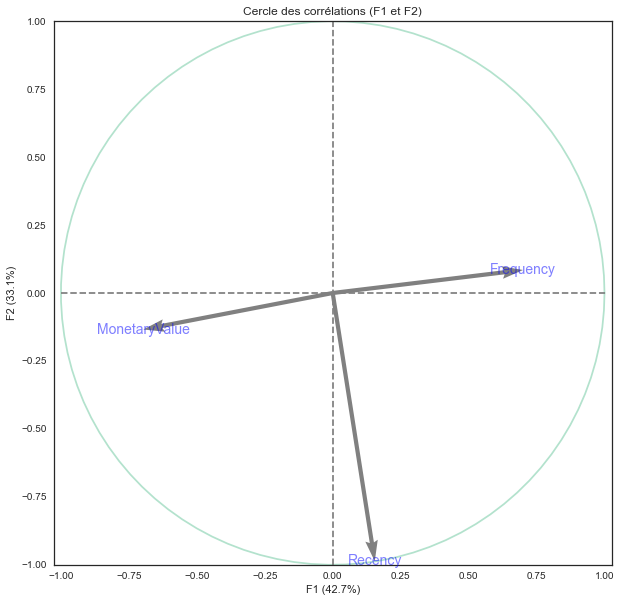

In [10]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

# 2) Modélisation : K-Means

Une fois les étapes de pré-traitement réalisés, on va pouvoir passer à la modélisation. On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et un point nommé centroïde. Il est possible d'entrer les coordonnées de ce centroïde. Dans notre situation, on ne possède pas de contrainte sur le placement de ces centroïdes, on va donc laisser ce paramètre s'initialiser aléatoirement. En revanche, on va chercher à déterminer le nombre de clusters (le K du K-Means). Pour cela, on s'intéresse à l'évolution des distorsions avec la "méthode du coude" (**Elbow Method**). 

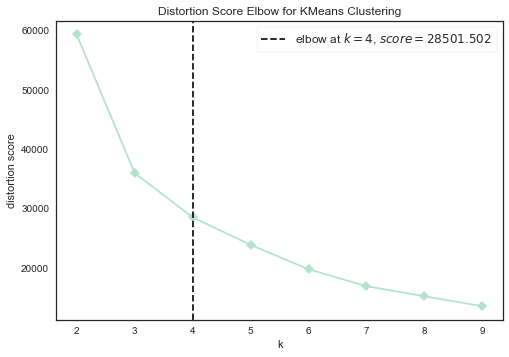

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show()

Selon la méthode du coude, le nombre de cluster idéal est de **4**. On va donc entraîner notre modèle avec ce paramètre.

In [12]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

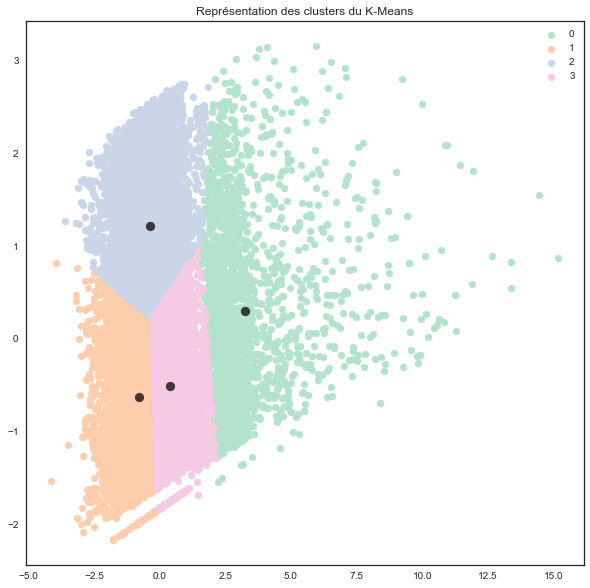

In [13]:
# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(data_pca)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_pca[label==i, 0], data_pca[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

## 2.1) Description des clusters obtenus avec le modèle

In [14]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,312.44,2.60,41.93
1,348.84,1.00,291.26
2,120.81,1.01,141.72
3,370.74,1.03,69.96


In [15]:
df_normalized = pd.DataFrame(customers_normalized,
                             columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,000e309254ab1fc5ba99dd469d36bdb4,0,Recency,-1.227794
1,0028a7d8db7b0247652509358ad8d755,3,Recency,0.378207
2,00324c9f4d710e7bac5c5ba679714430,0,Recency,1.106087
3,0058f300f57d7b93c477a131a59b36c3,0,Recency,-0.258102
4,00986cafefb6e670cceca01694bda599,0,Recency,0.274870


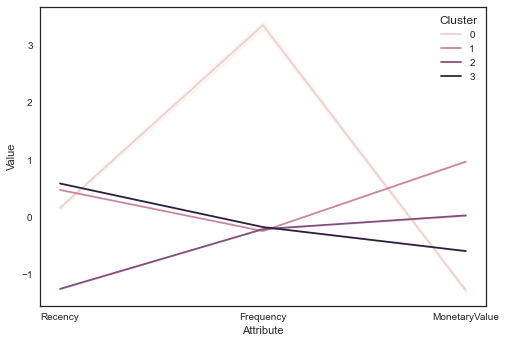

In [16]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

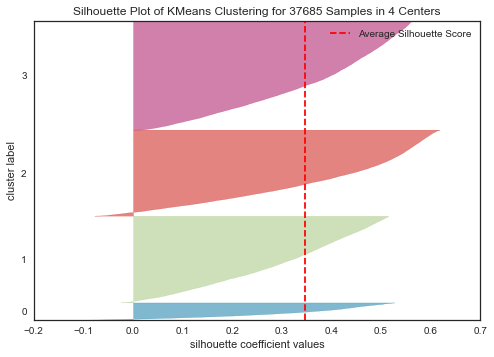

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 37685 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)
visualizer.show()

In [18]:
print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.34580451153696035
Score de Davies-Bouldin: 0.9227478495800008


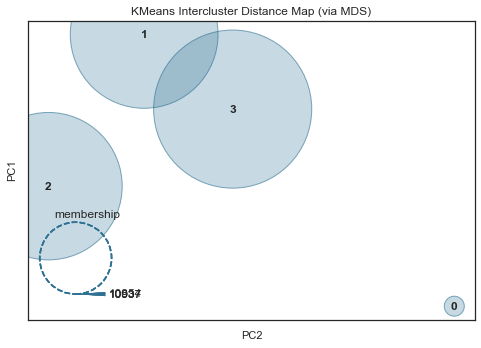

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [19]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), data_pca)

## 2.2) Conclusion

Trois de nos clusters semblent équilibrés et le dernier est plutôt faible. Ce cluster le plus petit est celui qui contient les clients ayant une fréquence d'achat supérieur à 2. Il s'agit donc des clients qui ont crée un compte et qui sont susceptibles de revenir régulièrement. Le reste des indices montre un clustering de bonne qualité. Cependant, la lecture des données ne permet de distinguer de véritables segmentations actionnables (outre les clients fidèles). On va donc essayer d'affiner cette segmentation en y ajoutant des variables supplémentaires. 

In [20]:
del data_pca
del df
del customers
del df_normalized
del df_nor_melt

In [21]:
gc.collect()

12540

# 3) Segmentation sur 5 variables explicatives

In [22]:
data = pd.read_csv("datasets/data_short.csv")
data.set_index("customer_unique_id", inplace=True)
data.head()

,customer_city,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,,,,,
000e309254ab1fc5ba99dd469d36bdb4,valparaiso de goias,115,2,39.210,1,2,4,124,497.666327,fashion_underwear_beach,14.0,3
0028a7d8db7b0247652509358ad8d755,valinhos,309,2,177.435,3,2,1,321,363.245845,office_furniture,23.0,3
00324c9f4d710e7bac5c5ba679714430,paraiso do tocantins,483,2,54.890,4,2,4,424,1480.276994,housewares,12.0,5
0058f300f57d7b93c477a131a59b36c3,salvador,209,2,48.010,2,2,4,224,1323.423777,luggage_accessories,13.0,5
00986cafefb6e670cceca01694bda599,pedreira,290,2,33.455,3,2,4,324,779.771352,stationery,11.0,4


In [23]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(data['Recency'])
customers["Frequency"] = np.log1p(data["Frequency"])
customers["MonetaryValue"] = np.log1p(data["MonetaryValue"])
customers["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
customers["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
customers.tail()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
f836eb0cd308c629611bc83ba1b5b48e,6.327937,0.693147,5.035263,3.218876,7.333904
e063ef265d53421046ccf982e627d690,5.638355,0.693147,3.811318,3.091042,5.980830
8971e7d7e0698aa8c102482725f5f775,4.442651,0.693147,3.342862,0.693147,4.685227
8489a779297d411d3bf70f720512af54,5.762051,0.693147,3.943909,2.890372,3.590591
f448091e9f88e875eedd3f5542f0524b,4.465908,0.693147,4.966265,1.945910,5.311342


In [24]:
scaler = StandardScaler()
customers_normalized = scaler.fit_transform(customers)

In [25]:
n_comp = 2
pca = PCA(n_components=n_comp)
customers_transform = pca.fit_transform(customers_normalized)
features = customers.columns
pcs = pca.components_

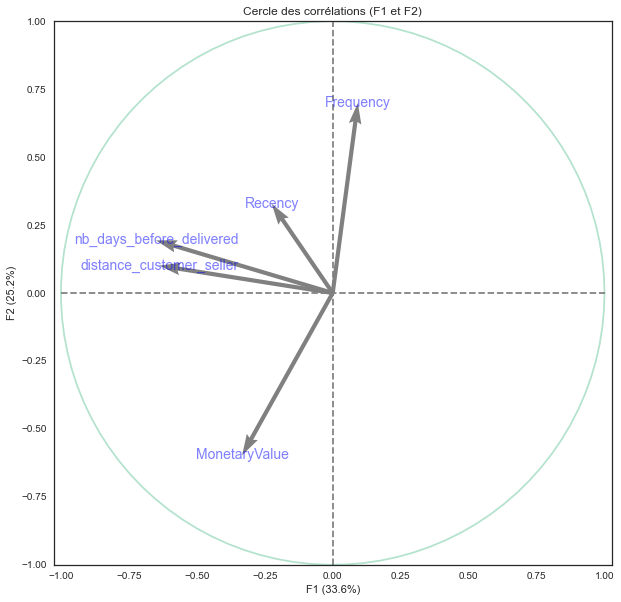

In [26]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

## 3.2) Modélisation : K-Means

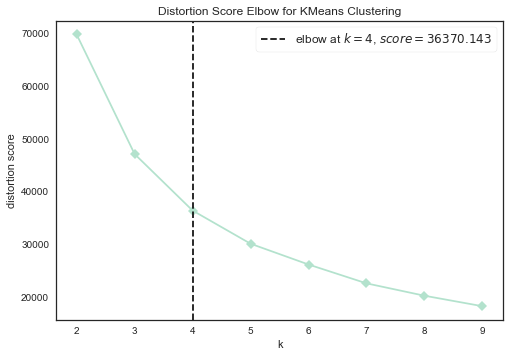

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
model = KMeans()
visualizer = KElbowVisualizer(model, k =(2,10), timings=False)
visualizer.fit(customers_transform)
visualizer.show()

In [28]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

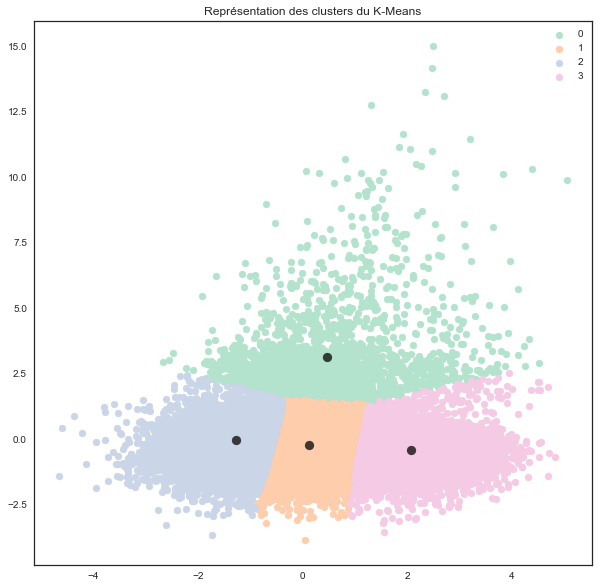

In [29]:
model = KMeans(n_clusters=4, random_state=42)

label = model.fit_predict(customers_transform)
centroids = model.cluster_centers_
u_labels = np.unique(label)

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(customers_transform[label == i , 0] ,customers_transform[label == i , 1] , label=i)
plt.scatter(centroids[:,0], centroids[:,1] , s = 80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [30]:
data["Cluster"] = model.labels_
data_clusters_analysis = data.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'nb_days_before_delivered' : "mean",
    "distance_customer_seller" : "mean",
    "product_category_name" : lambda x : x.value_counts().index[0],
    "customer_city" : lambda x : x.value_counts().index[0],
    "review_score" : "mean"}).round(2)
data_clusters_analysis

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller,product_category_name,customer_city,review_score
Cluster,,,,,,,,
0,328.43,2.58,47.56,12.56,633.54,bed_bath_table,sao paulo,4.11
1,271.63,1.01,138.53,8.54,448.02,bed_bath_table,sao paulo,4.28
2,333.19,1.01,216.81,19.21,1052.16,bed_bath_table,rio de janeiro,3.85
3,229.73,1.02,98.20,3.83,71.63,health_beauty,sao paulo,4.37


In [31]:
df_normalized = pd.DataFrame(customers_normalized, columns=["Recency",
                                                            "Frequency",'MonetaryValue', 
                                                            "nb_days_before_delivered", "distance_customer_seller"])
df_normalized['ID'] = data.index
df_normalized["Cluster"] = model.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",
                                  "nb_days_before_delivered", "distance_customer_seller"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,000e309254ab1fc5ba99dd469d36bdb4,0,Recency,-1.227794
1,0028a7d8db7b0247652509358ad8d755,2,Recency,0.378207
2,00324c9f4d710e7bac5c5ba679714430,0,Recency,1.106087
3,0058f300f57d7b93c477a131a59b36c3,0,Recency,-0.258102
4,00986cafefb6e670cceca01694bda599,0,Recency,0.274870


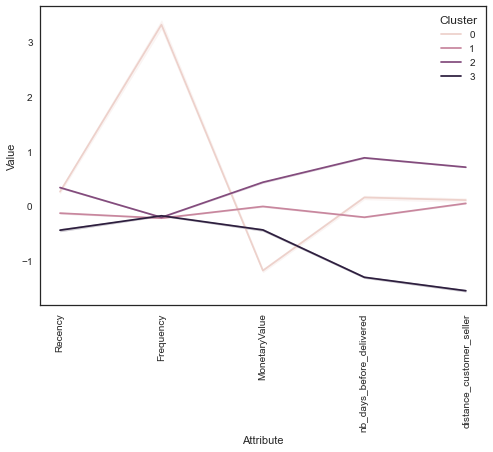

In [32]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.show()

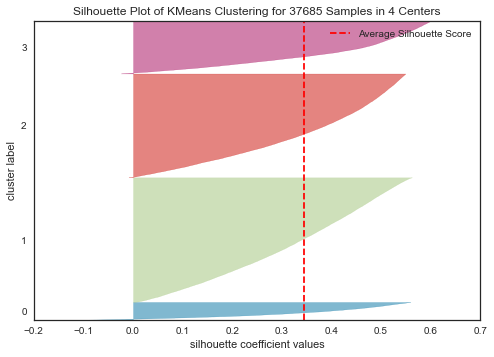

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 37685 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(customers_transform)
visualizer.show()

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", \
      silhouette_score(customers_transform,\
                       label))
print("Score de Davies-Bouldin:", \
      davies_bouldin_score(customers_transform,\
                           label))

Silhouette Score: 0.34545445872081637
Score de Davies-Bouldin: 0.9158927150770095


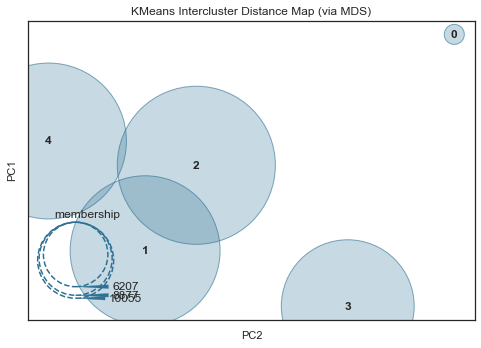

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=42))

In [35]:
intercluster_distance(KMeans(5, random_state=42), customers_transform)

In [36]:
data.to_csv("datasets/data_kmeans_clusters.csv")

## 3.2) Stabilité du clustering

On s'intéresse à la stabilité de notre algorithme pour déterminer les dates de maintenance de ce dernier. 

In [37]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])

In [38]:
data_test_180d = data_stability.loc[data["Recency"] < 180]

In [39]:
customers_stability = customers.drop(index=data_test_180d.index)
customers_stability["Recency"] = customers_stability["Recency"].values \
                               - np.log1p(180)

In [40]:
customers_stability.head()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
customer_unique_id,,,,,
0028a7d8db7b0247652509358ad8d755,0.538075,1.098612,5.184224,3.178054,5.897829
00324c9f4d710e7bac5c5ba679714430,0.983588,1.098612,4.023385,2.564949,7.300660
0058f300f57d7b93c477a131a59b36c3,0.148610,1.098612,3.892024,2.639057,7.188733
00986cafefb6e670cceca01694bda599,0.474826,1.098612,3.539654,2.484907,6.660282
00a9fd000ff87bb48b989df819c418f5,0.162795,1.609438,4.187379,1.945910,7.013105


In [41]:
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label1 = model.predict(customers_test_stab)

In [42]:
stability = pd.DataFrame({"label_begin" : label1},
                         index=customers_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0028a7d8db7b0247652509358ad8d755,1
00324c9f4d710e7bac5c5ba679714430,3
0058f300f57d7b93c477a131a59b36c3,3


In [43]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                 + np.log1p(30)

In [44]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label2 = model.predict(customers_test_stab)
stability["label_30d"] = label2

In [45]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label3 = model.predict(customers_test_stab)
stability["label_60d"] = label3

In [46]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label4 = model.predict(customers_test_stab)
stability["label_90d"] = label4

In [47]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label5 = model.predict(customers_test_stab)
stability["label_120d"] = label5

In [48]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                                + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label6 = model.predict(customers_test_stab)
stability["label_150d"] = label6

In [49]:
customers_stability["Recency"] = customers_stability["Recency"].values \
                               + np.log1p(30)
customers_test_stab = scaler.transform(customers_stability)
customers_test_stab = pca.transform(customers_test_stab)
label7 = model.predict(customers_test_stab)
stability["label_180d"] = label7

In [50]:
stability.head(3)

,label_begin,label_30d,label_60d,label_90d,label_120d,label_150d,label_180d
customer_unique_id,,,,,,,
0028a7d8db7b0247652509358ad8d755,1,0,0,0,0,0,0
00324c9f4d710e7bac5c5ba679714430,3,0,0,0,0,0,0
0058f300f57d7b93c477a131a59b36c3,3,0,0,0,0,0,0


In [51]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :", \
      adjusted_rand_score(stability['label_begin'], \
                          stability["label_30d"]))
print("ARI à 2 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_60d"]))
print("ARI à 3 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_90d"]))
print("ARI à 4 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_120d"]))
print("ARI à 5 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_150d"]))
print("ARI à 6 mois :", \
      adjusted_rand_score(stability["label_begin"], \
                          stability["label_180d"]))

ARI à 1 mois : -0.07075352638636973
ARI à 2 mois : 0.2298445443482099
ARI à 3 mois : 0.13719220009925173
ARI à 4 mois : 0.019550011301484357
ARI à 5 mois : 0.0006959395392472148
ARI à 6 mois : 0.0


La stabilité de notre modèle se dégrade très vite. Une maintenance mensuelle sera nécessaire pour pouvoir obtenir une segmentation qui ait encore du sens. 

In [52]:
stability.to_csv("datasets/stability.csv")
data_clusters_analysis.to_csv("datasets/clustering_analysis.csv")
data.to_csv("datasets/data_clusters.csv")

In [53]:
del stability
del data_clusters_analysis
del customers_stability

In [54]:
gc.collect()

12578

## 3.3) Conclusion

L'ajout de variable a permis d'obtenir une segmentation en 5 segments. On remarque que nos segments sont plutôt équilibrés mais qu'un segment contient moins de clients. Il s'agit des clients qui ont plusieurs commandes à leurs actifs. Il est aussi possible de distinguer des clients qui commandent à des vendeurs proches de leur lieu d'habitation ou encore des clients qui dépensent plus que les autres. 

Cependant, ce modèle ne semble pas stable et nécessitera une maintenance régulière. Ce problème de maintenance pourrait être combler par l'utilisation d'un algorithme incorporant d'autres variables, comme des variables catégorielles, mais aussi en obtenant des informations plus stables pour la récence et la fréquence. 

# 4) Segmentation sur 8 variables

## 4.1) Préparation des données

In [55]:
data.drop(["Cluster",
           "r_quartile",
           "f_bins",
           "m_quartile",
           "RFM_Score"],
           axis=1, inplace=True)

In [56]:
data.head()

,customer_city,Recency,Frequency,MonetaryValue,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
customer_unique_id,,,,,,,,
000e309254ab1fc5ba99dd469d36bdb4,valparaiso de goias,115,2,39.210,497.666327,fashion_underwear_beach,14.0,3
0028a7d8db7b0247652509358ad8d755,valinhos,309,2,177.435,363.245845,office_furniture,23.0,3
00324c9f4d710e7bac5c5ba679714430,paraiso do tocantins,483,2,54.890,1480.276994,housewares,12.0,5
0058f300f57d7b93c477a131a59b36c3,salvador,209,2,48.010,1323.423777,luggage_accessories,13.0,5
00986cafefb6e670cceca01694bda599,pedreira,290,2,33.455,779.771352,stationery,11.0,4


In [57]:
cols = data.columns

for col in cols:
    if data[col].dtypes == "float":
        data[col] = np.log1p(data[col].values)

In [58]:
cat_var = ["review_score", "customer_city", "product_category_name"]
num_var = ["Frequency", "Recency", "nb_days_before_delivered",
           "MonetaryValue", "distance_customer_seller"]

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [60]:
data.columns

Index(['customer_city', 'Recency', 'Frequency', 'MonetaryValue',
       'distance_customer_seller', 'product_category_name',
       'nb_days_before_delivered', 'review_score'],
      dtype='object')

In [61]:
data_normalized = preprocessor.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=["review_score",
                                                         "customer_city",
                                                         "product_category_name",
                                                         "Frequency",
                                                         "Recency",
                                                         "nb_days_before_delivered",
                                                         "MonetaryValue",
                                                         "distance_customer_seller"])

In [62]:
for col in num_var:
    data_normalized[col] = data_normalized[col].astype("float32")

In [63]:
catColumnsPos = [data_normalized.columns.get_loc(col)\
                 for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['review_score', 'customer_city', 'product_category_name']
Categorical columns position  : [0, 1, 2]


In [64]:
dfMatrix = data_normalized.to_numpy()

## 4.2) Modélisation : K-Prototype

L'algorithme K-Prototype est un algorithme de la même famille que le K-Means. Cependant, le K-Prototype permet d'ajouter des variables catégorielles dans notre segmentation. On ajoute en plus des variables présentées dans le modèle précédents, la ville d'origine du client, l'avis moyen donné lors de ces commandes et le type de produits commandé. 

On choisit de diviser notre échantillon en 4 clusters.

In [65]:
kprototype = KPrototypes(n_jobs=-1,
                         n_clusters=4,
                         init='Huang',
                         random_state=42)
kprototype.fit_predict(dfMatrix,
                       categorical=catColumnsPos)

array([0, 0, 3, ..., 2, 2, 0], dtype=uint16)

In [66]:
data['cluster_id'] = kprototype.labels_

## 4.3) Analyse du clustering

In [67]:
data["review_score"] = data["review_score"].astype("int32")

In [68]:
for col in cols:
    if data[col].dtypes == "float":
        data[col] = np.expm1(data[col].values)

In [69]:
data_kproto_analysis = data.groupby('cluster_id').agg({
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'distance_customer_seller' : "mean",
    'nb_days_before_delivered' : "mean",
    'product_category_name' : lambda x: x.value_counts().index[0],
    'customer_city' : lambda x: x.value_counts().index[0],
    'review_score':"mean"}).round(2)

In [70]:
data_kproto_analysis

,Frequency,MonetaryValue,distance_customer_seller,nb_days_before_delivered,product_category_name,customer_city,review_score
cluster_id,,,,,,,
0,1.05,189.07,786.32,14.62,bed_bath_table,sao paulo,4.01
1,6.20,25.22,578.70,12.07,bed_bath_table,sao paulo,4.17
2,1.07,104.25,79.50,4.46,health_beauty,sao paulo,4.35
3,1.10,134.83,693.27,12.20,bed_bath_table,sao paulo,4.18


In [71]:
data_kproto_analysis.to_csv("datasets/data_kproto_analysis.csv")

In [72]:
del dfMatrix

In [73]:
data.to_csv("datasets/data_kprototype_clusters.csv")

## 4.4) Stabilité de l'algorithme

On va chercher à établir la stabilité de l'algorithme pour définir les moments où réaliser des maintenances de notre algorithme. 

In [74]:
data_stability = pd.DataFrame()
data_stability["Recency"] = np.log1p(data["Recency"])
data_stability["Frequency"] = np.log1p(data["Frequency"])
data_stability["MonetaryValue"] = np.log1p(data["MonetaryValue"])
data_stability["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
data_stability["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
data_stability["product_category_name"] = data["product_category_name"]
data_stability["customer_city"] = data["customer_city"]
data_stability["review_score"] = data["review_score"]

In [75]:
data_test_180d = data.loc[data["Recency"] < 180]

In [76]:
data_stability = data_stability.drop(index=data_test_180d.index)
data_stability["Recency"] = data_stability["Recency"].values - np.log1p(180)

In [77]:
data_stability = data_stability[['customer_city',
                                 'Recency',
                                 'Frequency',
                                 'MonetaryValue',
                                 'distance_customer_seller',
                                 'product_category_name',
                                 'nb_days_before_delivered',
                                 'review_score']]

In [78]:
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered", 
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
label1 = kprototype.predict(dfMatrix, categorical=catColumnsPos)

In [79]:
stability = pd.DataFrame({"label_begin" : label1},
                         index=data_stability.index)
stability.head(3)

,label_begin
customer_unique_id,
0028a7d8db7b0247652509358ad8d755,0
00324c9f4d710e7bac5c5ba679714430,0
0058f300f57d7b93c477a131a59b36c3,0


In [80]:
data_stability["Recency"] = data_stability["Recency"].values + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_30d"] = kprototype.predict(dfMatrix, categorical=catColumnsPos)

In [81]:
data_stability["Recency"] = data_stability["Recency"].values \
                          + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_60d"] = kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [82]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency", "Recency", "nb_days_before_delivered", 
                                                         "MonetaryValue", "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_90d"] = kprototype.predict(dfMatrix,
                                            categorical = catColumnsPos)

In [83]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns = ["review_score",
                                                                   "customer_city",
                                                                   "product_category_name",
                                                                   "Frequency",
                                                                   "Recency",
                                                                   "nb_days_before_delivered",
                                                                   "MonetaryValue",
                                                                   "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col) \
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_120d"] = kprototype.predict(dfMatrix,
                                             categorical = catColumnsPos)

In [84]:
data_stability["Recency"] = data_stability["Recency"].values \
                            + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_150d"] = kprototype.predict(dfMatrix,\
                                             categorical = catColumnsPos)

In [85]:
data_stability["Recency"] = data_stability["Recency"].values \
                          + np.log1p(30)
customers_test_stab = preprocessor.transform(data_stability)
customers_test_stab = pd.DataFrame(customers_test_stab, columns=["review_score",
                                                                 "customer_city",
                                                                 "product_category_name",
                                                                 "Frequency",
                                                                 "Recency",
                                                                 "nb_days_before_delivered",
                                                                 "MonetaryValue",
                                                                 "distance_customer_seller"])
for col in num_var:
    customers_test_stab[col] = customers_test_stab[col].astype("float32")
catColumnsPos = [customers_test_stab.columns.get_loc(col)\
                 for col in list(customers_test_stab.select_dtypes('object').columns)]
dfMatrix = customers_test_stab.to_numpy()
stability["label_180d"] = kprototype.predict(dfMatrix,
                                             categorical = catColumnsPos)

In [86]:
from sklearn.metrics import adjusted_rand_score

print("ARI à 1 mois :",\
      adjusted_rand_score(stability['label_begin'],\
                          stability["label_30d"]))
print("ARI à 2 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_60d"]))
print("ARI à 3 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_90d"]))
print("ARI à 4 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_120d"]))
print("ARI à 5 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_150d"]))
print("ARI à 6 mois :",\
      adjusted_rand_score(stability["label_begin"],\
                          stability["label_180d"]))

ARI à 1 mois : 0.9989816857900783
ARI à 2 mois : 0.9974558874380614
ARI à 3 mois : 0.9955937443809874
ARI à 4 mois : 0.9947483037448677
ARI à 5 mois : 0.993396881113031
ARI à 6 mois : 0.9920470346016338


Au bout de 6 mois, on remarque que notre segmentation évolue très peu. Il peut être envisagé de faire une maintenance de l'algorithme tous les ans si cette solution est adoptée. 

## 4.5) Conclusion

Le modèle K-Prototype permet d'obtenir des résultats similaires au K-Means et nécessite une maintenance moins importante. Cependant, pour rendre nos modélisations de meilleures qualités, il pourrait être intéressant d'obtenir des informations démographiques sur nos clients ainsi que de trouver un moyen de les suivre pour pouvoir utiliser les variables de récence et de fréquence d'achat qui sont pour le moment très peu discriminative. 

L'utilisation d'algorithme de Machine Learning permet d'obtenir des segments actionnables en prenant en compte plus de variable que les segmentations classiques, type RFM. On va aussi pouvoir obtenir moins de segments de clientèle (5 segments avec des algorithmes de clustering vs 32 segments avec la segmentation RFM). Il sera donc probablement plus aisé de faire des offres une fois les 5 segments définis que lorsqu'on a défini 32 segments. 

In [87]:
stability.to_csv("datasets/stability_kproto.csv")
data.to_csv("datasets/data_kprototype.csv")

**Références :**

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb